In [70]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression

Get hashrate data from NASDAQ API:

In [53]:
hr_response = requests.get('https://data.nasdaq.com/api/v3/datasets/BCHAIN/HRATE.json?api_key=CEZ47Us4M6dvsFYzReoG')
hr_data = hr_response.json()['dataset']['data']
hr_df = pd.DataFrame.from_records(hr_data, columns=['Date', 'Hashrate'])
hr_df['Day'] = list(reversed(range(0, len(hr_df.index))))
hr_df.sort_values(by='Day', ascending=True, inplace=True)
hr_df.reset_index(drop=True, inplace=True)
hr_df = hr_df[['Date', 'Day', 'Hashrate']]
hr_df['Date'] = pd.to_datetime(hr_df['Date'])
hr_df

,Date,Day,Hashrate
0,2009-01-03,0,0.000000e+00
1,2009-01-04,1,0.000000e+00
2,2009-01-05,2,0.000000e+00
3,2009-01-06,3,0.000000e+00
4,2009-01-07,4,0.000000e+00
...,...,...,...
5045,2022-10-27,5045,2.472001e+08
5046,2022-10-28,5046,2.911468e+08
5047,2022-10-29,5047,2.618490e+08
5048,2022-10-30,5048,2.472001e+08


Plot hashrate over time:

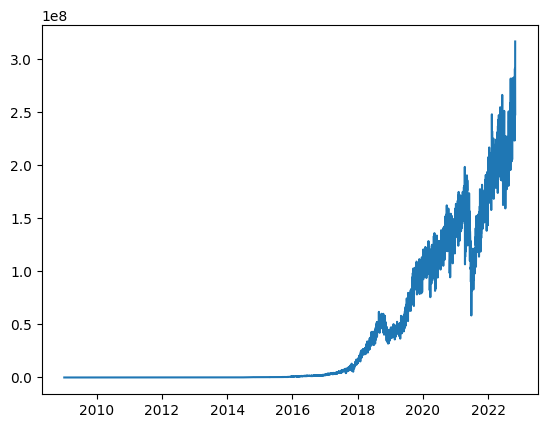

In [54]:
fig, ax = plt.subplots(1, 1)
ax.plot(hr_df['Date'], hr_df['Hashrate'])
plt.show()

Cut off early data to only start when hashrate starts taking off (post BTC adoption):

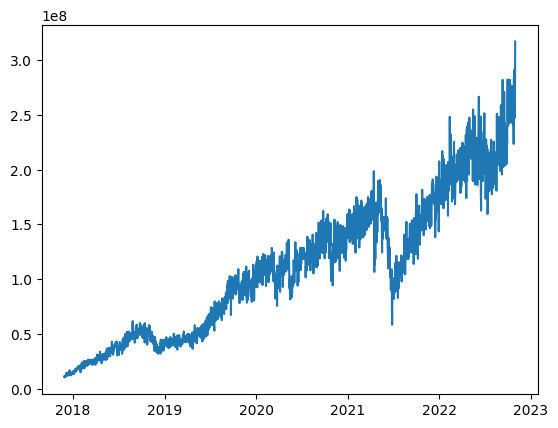

In [55]:
hr_df_short = hr_df.copy().loc[3250:, :]

fig, ax = plt.subplots(1, 1)
ax.plot(hr_df_short['Date'], hr_df_short['Hashrate'])
plt.show()

Fit a logarithmic regression and plot:

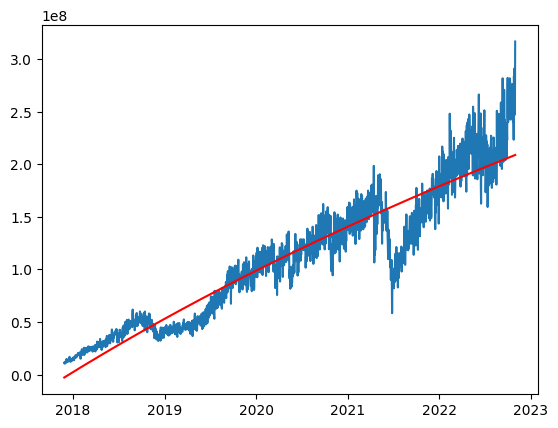

In [56]:
hr_df_short.loc[:, 'ln_Day'] = np.log(hr_df_short.loc[:, 'Day'])
linear_reg = LinearRegression()
linear_reg.fit(hr_df_short['ln_Day'].values.reshape(-1,1), hr_df_short['Hashrate'])
pred_hr = linear_reg.predict(hr_df_short['ln_Day'].values.reshape(-1, 1))

fig, ax = plt.subplots(1, 1)
ax.plot(hr_df_short['Date'], hr_df_short['Hashrate'])
ax.plot(hr_df_short['Date'], pred_hr, 'r')
plt.show()

Refit discounting the large drop in hashrate:

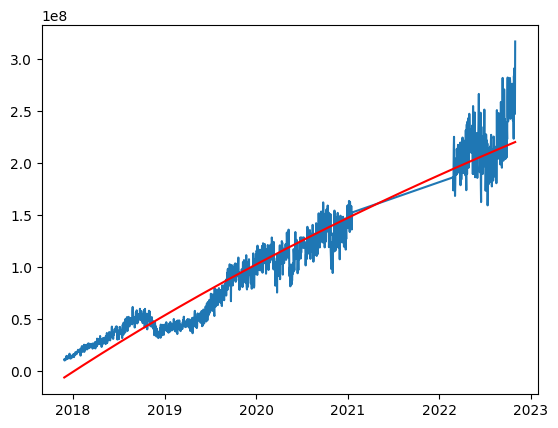

In [61]:
hr_df_cherry = hr_df_short.drop(list(range(4400, 4801)), axis=0)
linear_reg.fit(hr_df_cherry['ln_Day'].values.reshape(-1, 1), hr_df_cherry['Hashrate'])
pred_hr = linear_reg.predict(hr_df_short['ln_Day'].values.reshape(-1, 1))

fig, ax = plt.subplots(1, 1)
ax.plot(hr_df_cherry['Date'], hr_df_cherry['Hashrate'])
ax.plot(hr_df_short['Date'], pred_hr, 'r')
plt.show()

Project to day 1000:

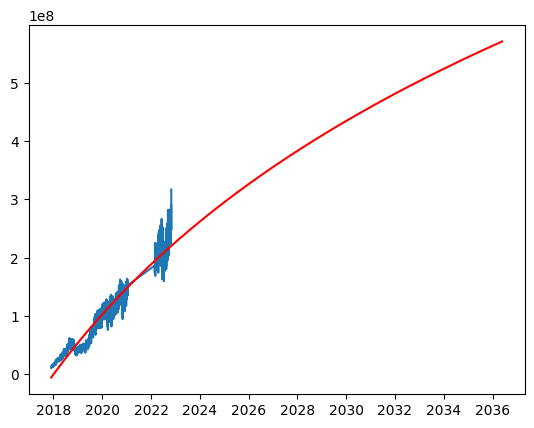

In [96]:
day_range = range(3250, 10001)
date_range = pd.to_datetime(range(1, len(day_range)+1), unit='D', origin=hr_df.loc[3250, 'Date'])

days_proj = np.array(day_range).reshape(-1,1)
days_proj_ln = np.log(days_proj)
pred_hr = linear_reg.predict(days_proj_ln)

fig, ax = plt.subplots(1, 1)
ax.plot(hr_df_cherry['Date'], hr_df_cherry['Hashrate'])
ax.plot(date_range, pred_hr, 'r')
plt.show()

Time to generate a collision if we devote entire BTC hashrate to SHA 256 calculation (using actual data from our shortened timeframe):

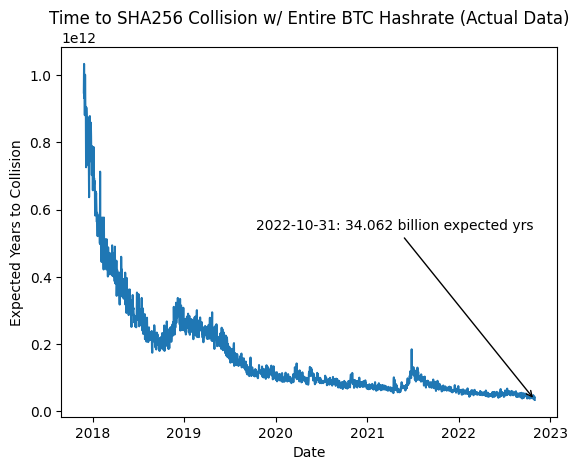

In [83]:
needed_hashes = 2**128
def hashrate_to_years(rate):
    seconds = needed_hashes / rate
    years = seconds / (60*60*24*365)
    return years

scaled_rates = hr_df_short.loc[:, 'Hashrate']*1000000000000
years_actual = scaled_rates.apply(hashrate_to_years)

fig, ax = plt.subplots(1, 1)
ax.plot(hr_df_short['Date'], years_actual)
ax.annotate(
    f'{hr_df_short.iloc[-1]["Date"].date()}: {round(years_actual.iloc[-1] / 10**9, 3)} billion expected yrs',
    xy=(hr_df_short.iloc[-1]["Date"], years_actual.iloc[-1]),
    xycoords='data',
    xytext=(0.4, 0.5),
    textcoords='figure fraction',
    arrowprops=dict(arrowstyle='->', facecolor='r')
)
plt.title('Time to SHA256 Collision w/ Entire BTC Hashrate (Actual Data)')
plt.xlabel('Date')
plt.ylabel('Expected Years to Collision')
plt.show()

Now do the same for projected data starting from present:

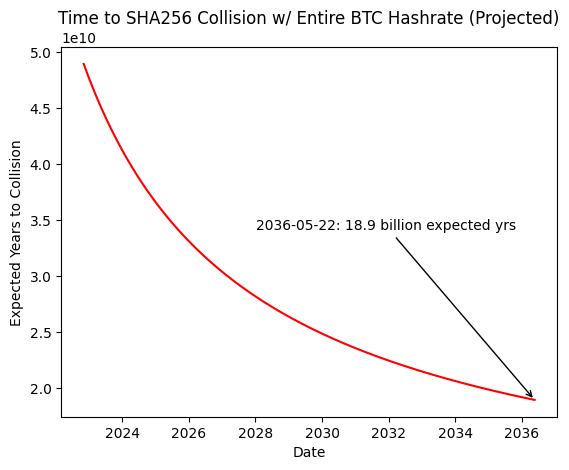

In [105]:
scaled_rates_proj = pred_hr[len(hr_df_short.index)+1:]*1000000000000
years_proj = pd.Series(scaled_rates_proj).apply(hashrate_to_years)

fig, ax = plt.subplots(1, 1)
ax.plot(date_range[len(hr_df_short.index)+1:], years_proj, 'r')
ax.annotate(
    f'{date_range[-1].date()}: {round(years_proj.iloc[-1] / 10**9, 3)} billion expected yrs',
    xy=(date_range[-1], years_proj.iloc[-1]),
    xycoords='data',
    xytext=(0.4, 0.5),
    textcoords='figure fraction',
    arrowprops=dict(arrowstyle='->')
)
plt.title('Time to SHA256 Collision w/ Entire BTC Hashrate (Projected)')
plt.xlabel('Date')
plt.ylabel('Expected Years to Collision')
plt.show()

In [118]:
linear_reg.coef_

array([5.1317144e+08])

In [120]:
pred_hr[730] - pred_hr[365]

49361942.14362526